In [186]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [305]:
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)
from sklearn.model_selection import train_test_split
from statsmodels.api import OLS
from functools import partial
from sklearn.metrics import mean_squared_error, r2_score

In [271]:
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)

In [120]:
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
(cross_validate,
KFold,
ShuffleSplit)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
#labs

In [ ]:
#############
#7.8.1 Polynomial Regression and Step Functions

In [4]:
#load the data
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [5]:
# use the poly() function to create a model matrix 
#that will fit a 4th degree polynomial in age.
#poly as a helper function, and sets up the transformation; 
#Poly() is the actual workhorse that computes the transformation
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [ ]:
#create a grid of values for age at which we want predictions.

In [7]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)#generates 100 evenly spaced values between the minimum and maximum 
age_df = pd.DataFrame({'age': age_grid})

In [8]:
#plot the data and add the fit from the fourth-degree polynomial.
def plot_wage_fit(age_df,
                  basis,
                  title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean ,
                        bands[:,0],
                        bands[:,1]],
                       ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Age', fontsize=20)
        ax.set_ylabel('Wage', fontsize=20);
        return ax

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

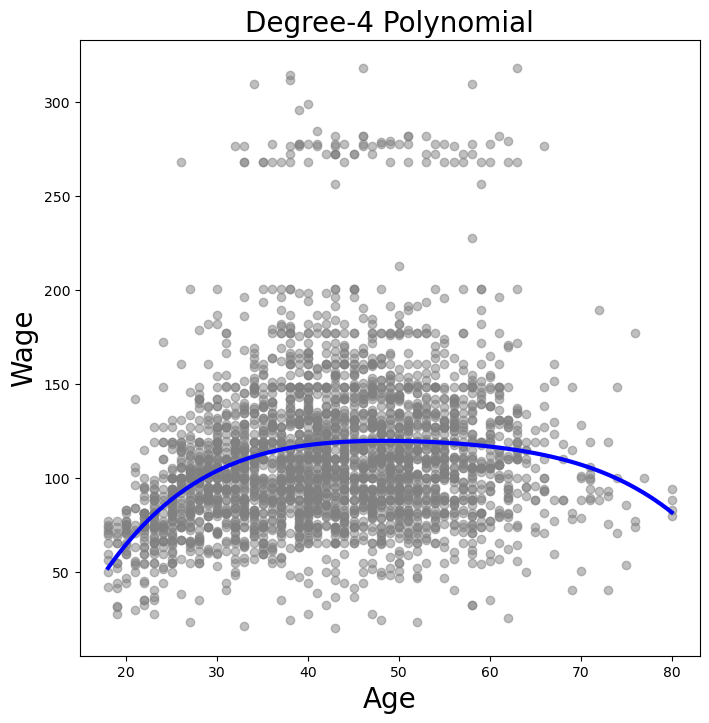

In [9]:
plot_wage_fit(age_df,
              poly_age,
              'Degree-4 Polynomial')

In [ ]:
#fit a series of models ranging from linear (degree-one) to degree-fve polynomials
#use the anova_lm() function, which performs a series of ANOVA tests
#The determination is based on an F-test

In [10]:
models = [MS([poly('age', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [ ]:
#degree-five polynomial models[4] seems unnecessary because its p-value is 0.37.

In [11]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [ ]:
#the square of the t-statistics are equal to the F-statistics

In [12]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [13]:
#apply the glm() function using the binomial family in order to ft a polynomial logistic regression model.
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [14]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

Text(0, 0.5, 'P(Wage > 250)')

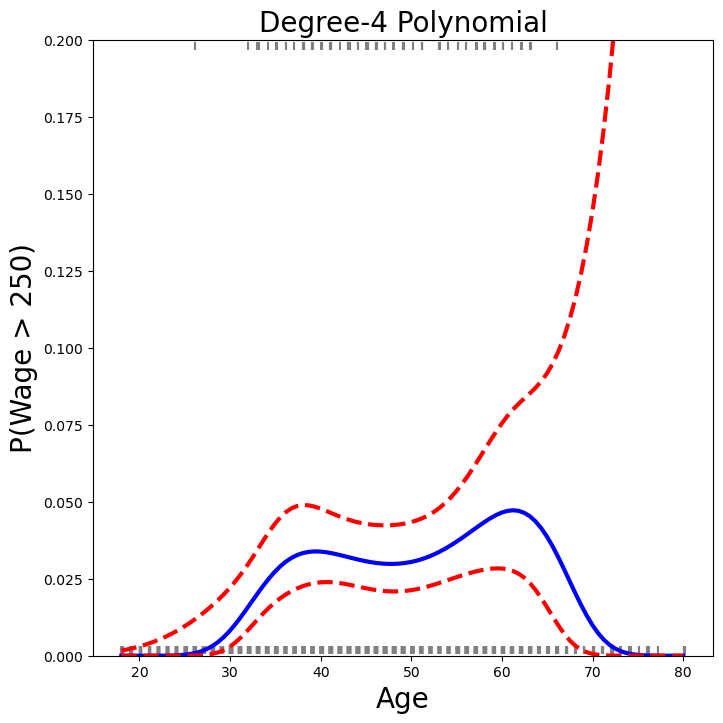

In [16]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean ,
                    bands[:,0],
                    bands[:,1]],
                   ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20)

In [18]:
#fit a step function
cut_age = pd.qcut(age, 4)#pd.qcut() function to discretize age based on quantiles
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [19]:
###############################################
#7.8.2 Splines

In [20]:
#To change the degree, use the argument degree. BSpline() default cubic
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape
#This results in a seven-column matrix, which is what is expected for a cubicspline basis with 3 interior knots.

(3000, 7)

In [21]:
# form this same matrix using the bs() object
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [23]:
# set the previous on construction
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [ ]:
#are 6 spline coefcients rather than 7. This is because, by default, bs() assumes intercept=False,

In [ ]:
#

In [24]:
#use the df (degrees of freedom) option to specify the complexity of the spline.
BSpline(df=6).fit(age).internal_knots_
#When asking for six degrees of freedom, the transform chooses knots at ages 33.75, 42.0, and 51.0 
#25th, 50th, and 75th percentiles of age

array([33.75, 42.  , 51.  ])

In [26]:
#When using B-splines we need not limit ourselves to cubic polynomials (i.e. degree=3). For instance, 
#using degree=0 results in piecewise constant functions
bs_age0 = MS([bs('age',
                 df=3,
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())
#94.158 + 22.349 = 116.507 ≈ 116.611, line18

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [27]:
# fit a natural spline with fve Natural Spline() degrees of freedom
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


<Axes: title={'center': 'Natural spline, df=5'}, xlabel='Age', ylabel='Wage'>

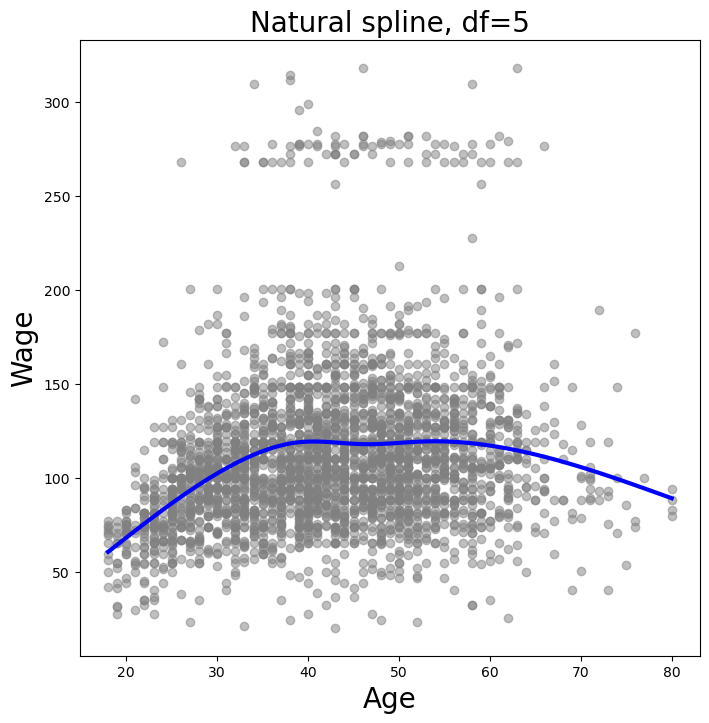

In [28]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5')

In [ ]:
##############################
#7.8.3 Smoothing Splines and GAMs

In [30]:
#lam is the penalty parameter λ
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6)) #s for smoothing spline; l for linear, and f for factor or categorical variables
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

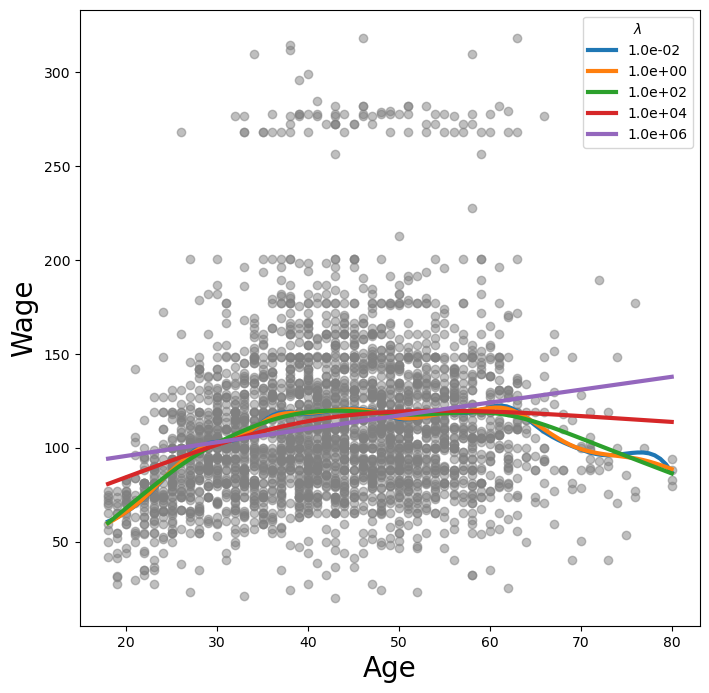

In [32]:
# fit changes with the smoothing parameter lam vary lam from 10^−2 to 10^6.
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):#5 is the number of point
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$')

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


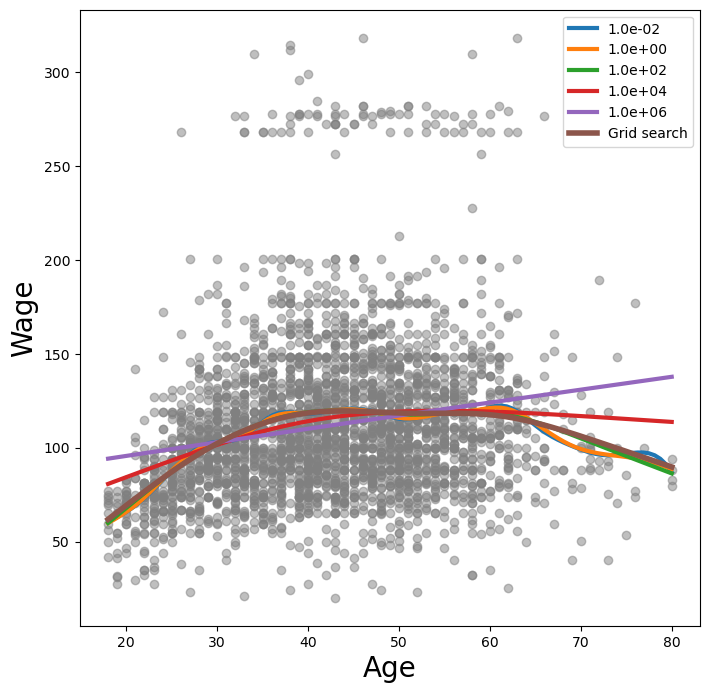

In [33]:
#perform a search for an optimal smoothing parameter
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

In [34]:
#fix the degrees of freedom of the smoothing spline using a function included in the ISLP.pygam package.
#include the unpenalized intercept and linear term of the smoothing spline,  hence at least two degrees of freedom
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100001163

In [ ]:
#degree of frreedom = desired degrees of freedom + 1(intercept)

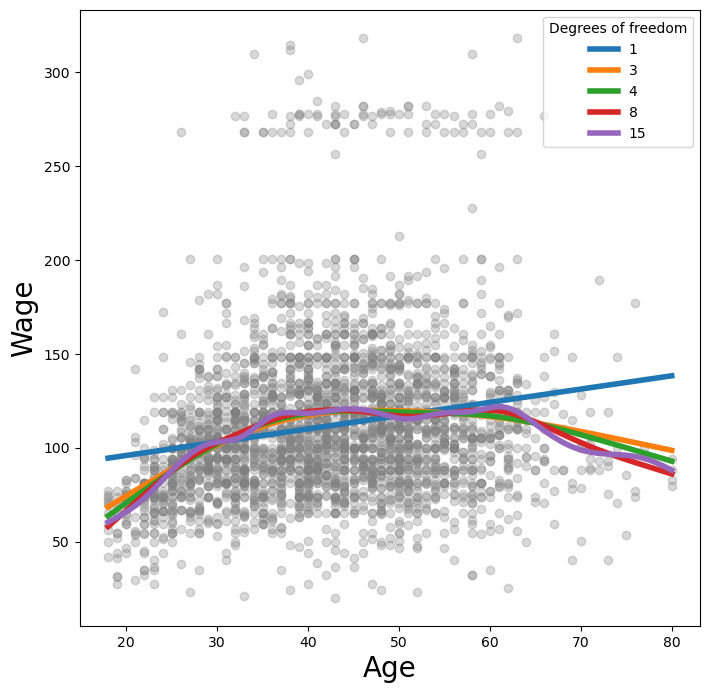

In [35]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom')

In [ ]:
##########Additive Models with Several Terms

In [36]:
#predict wage using natural spline functions of year and age, treating education as a qualitative predictor(7.16
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

In [ ]:
#given grids for age and year
# predict with new X matrices, fxing all but one of the features at a time

Text(0.5, 1.0, 'Partial dependence of age on wage')

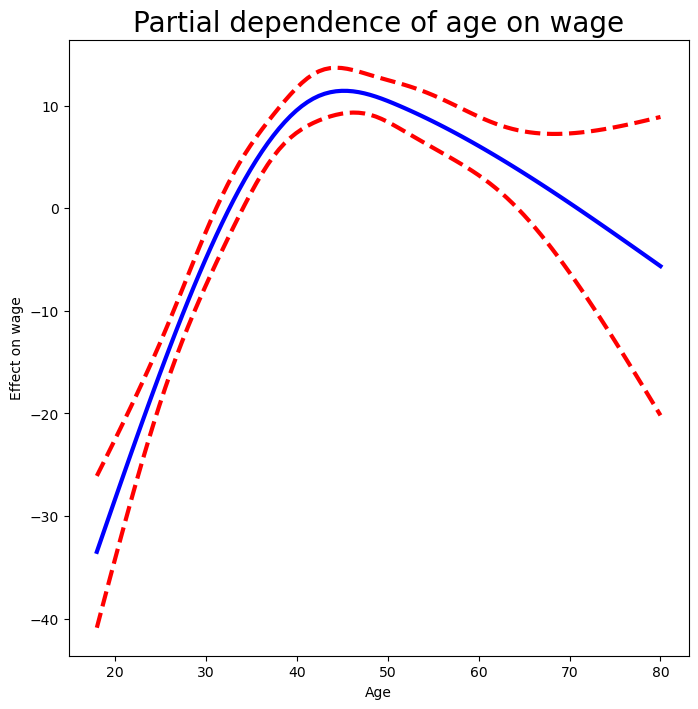

In [38]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)# made a grid of length 100 in age
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]#replaced every row of this matrix with the column means
X_age_bh[:,:4] = ns_age.transform(age_grid) #replace just the frst four columns representing age with the natural spline basis computed at the values in age_grid.
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20)

In [ ]:
# the efect of year on wage

Text(0.5, 1.0, 'Partial dependence of year on wage')

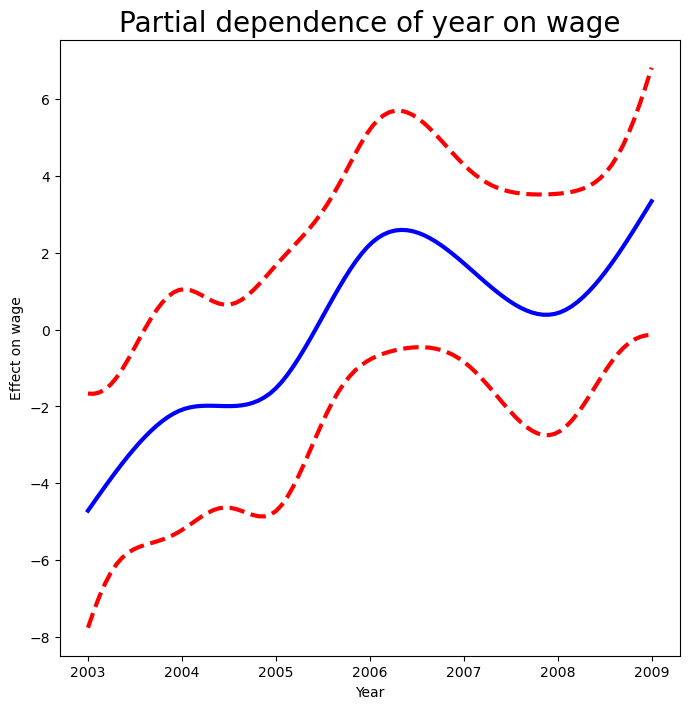

In [39]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year , 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

In [ ]:
# fit the model (7.16) using smoothing splines rather than natural splines

In [42]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +#two s_gam() terms result in smoothing spline fts # a default value for λ (lam=0.6
                     f_gam(2, lam=0)) #specify lam=0 to avoid any shrinkage
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes]) #convert the categorical series education to its array representation
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

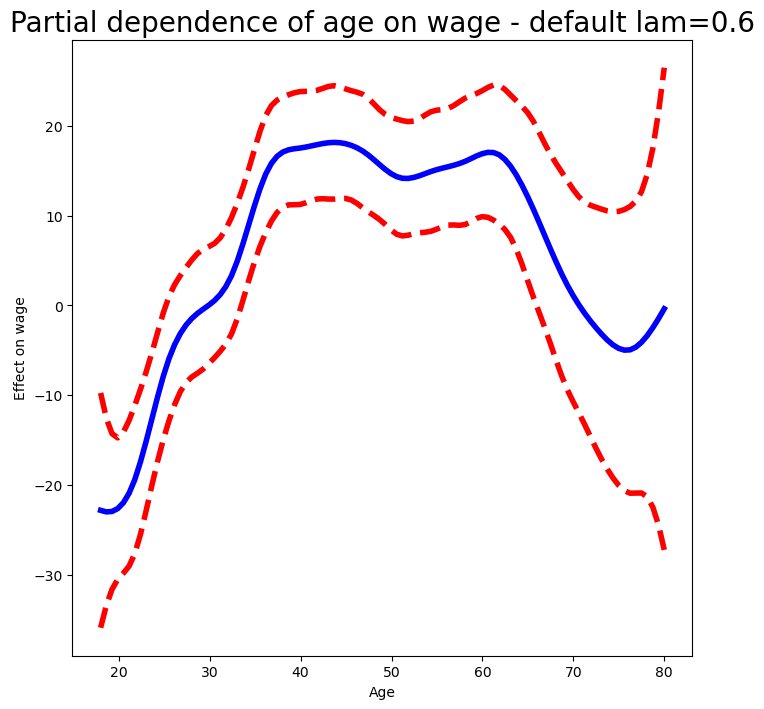

In [43]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
             fontsize=20)

In [ ]:
# the function is somewhat wiggly. It is more natural to specify the df than a value for lam.

In [45]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1) #take into account the intercept of the smoothing spline
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

In [ ]:
#Note that updating age_term.lam above updates it in gam_full.terms[0] as well! Likewise for year_term.lam.

Text(0.5, 1.0, 'Partial dependence of year on wage')

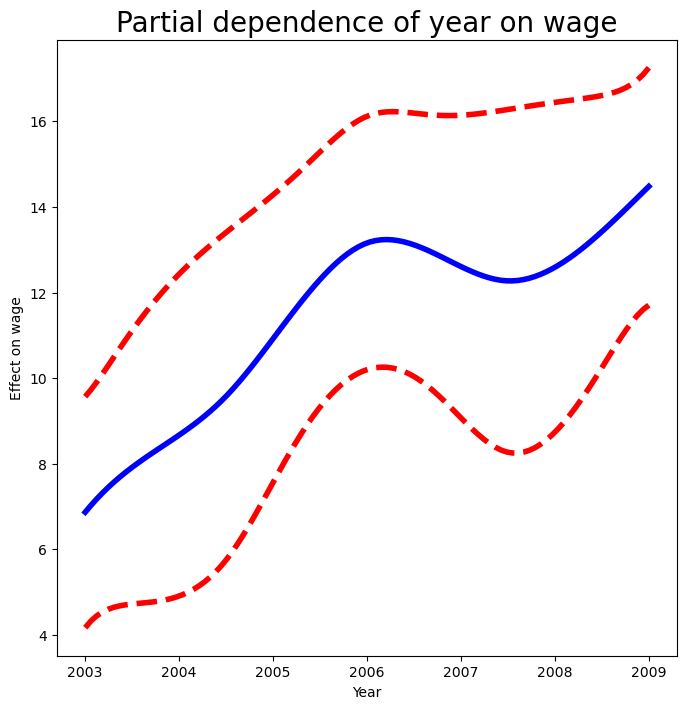

In [46]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

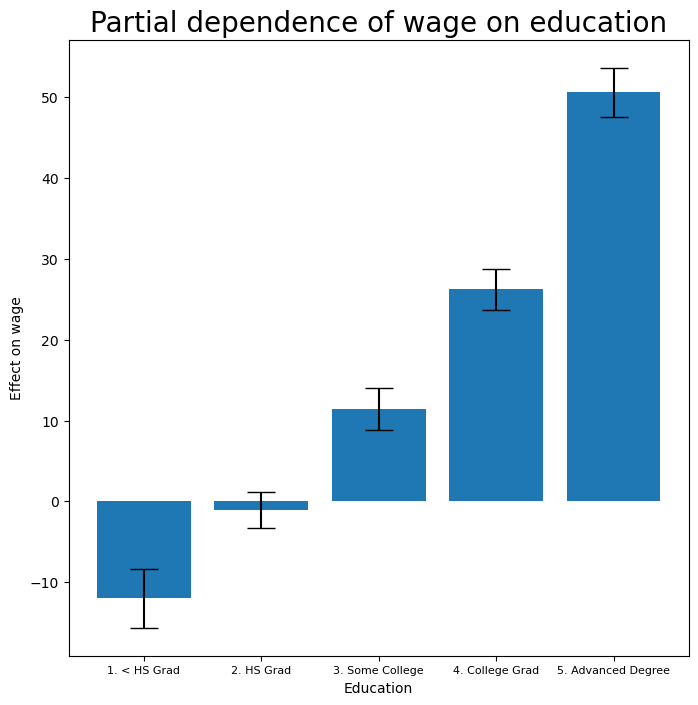

In [47]:
#Finally we plot education
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)#convert the categorical series education to its array representation

In [ ]:
#ANOVA Tests for Additive Models

In [ ]:
#perform a series of ANOVA tests in order to determine which of these three models is best

In [ ]:
#a GAM that excludes year (M1), 
#a GAM that uses a linear function of year (M2), 
#or a GAM that uses a spline function of year (M3)

In [48]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [49]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [ ]:
# In other words, based on the results of this ANOVA, M2 is preferred

In [ ]:
#  repeat the same process for age as well.

In [50]:
gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [51]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/var/folders/4t/w05mrsdn0r9d85szm0g3kg740000gn/T/ipykernel_80099/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [52]:
Yhat = gam_full.predict(Xgam)

In [ ]:
#ft a logistic regression GAM

In [53]:
gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

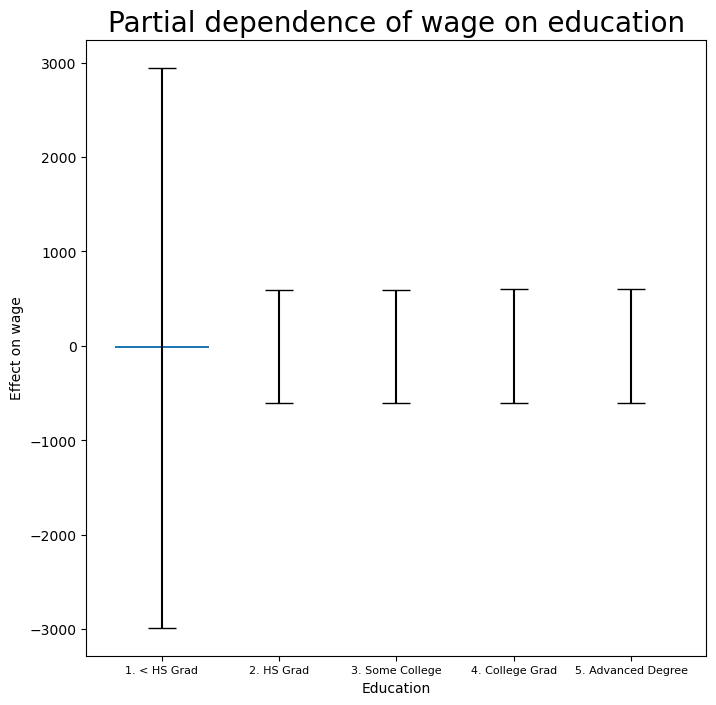

In [54]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

In [55]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [ ]:
#d subset the model matrix

In [ ]:
#deduce which column corresponds to this feature, 
#for reproducibility’s sake we reform the model matrix on this smaller subset

In [58]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
Wage_['year'],
Wage_['education'].cat.codes -1])
high_earn_ = Wage_['high_earn']

In [59]:
#fit the model
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

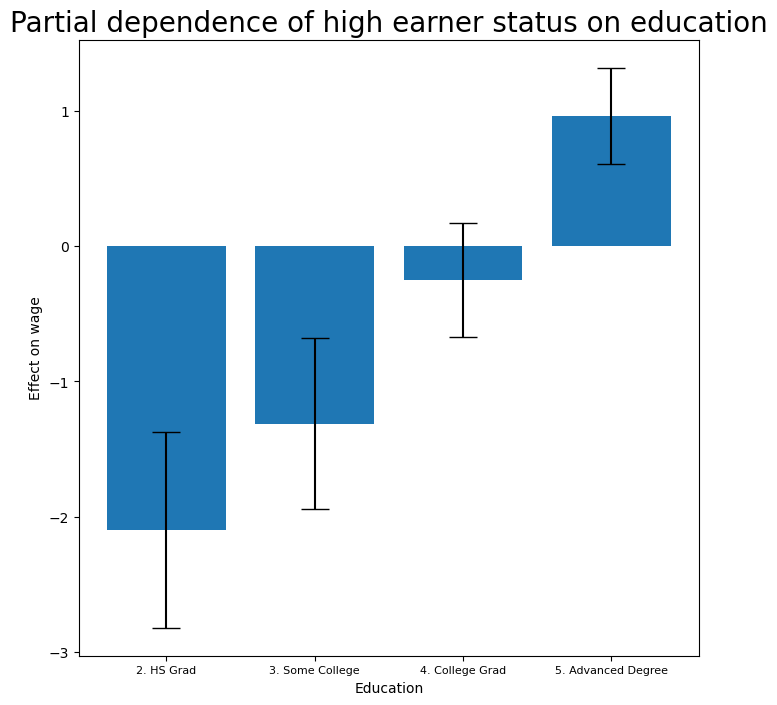

In [60]:
# at the efect of education, year and age on high earner status
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education'
             , fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
                   fontsize=8)

Text(0.5, 1.0, 'Partial dependence of high earner status on year')

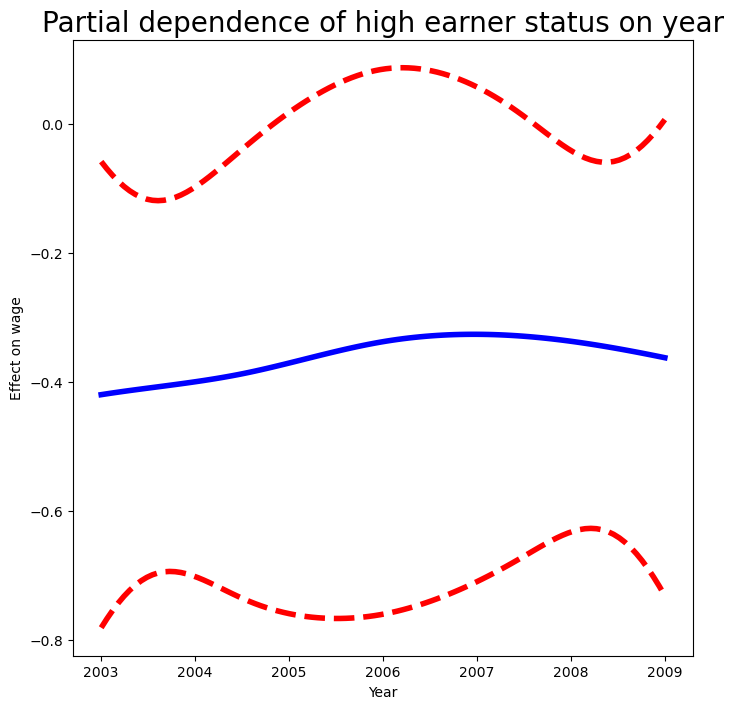

In [62]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
             fontsize=20)

Text(0.5, 1.0, 'Partial dependence of high earner status on age')

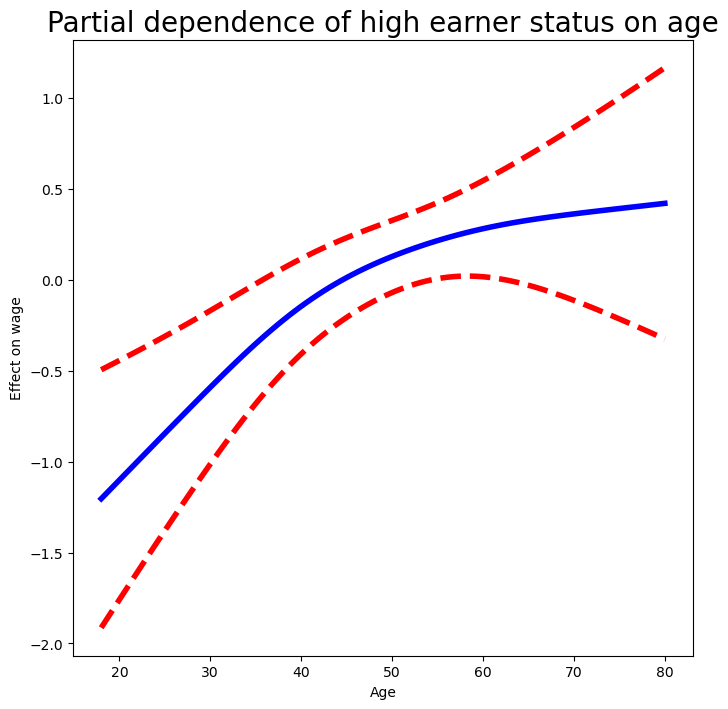

In [64]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
             fontsize=20)

In [ ]:
###########exercises

In [ ]:
#6.

In [ ]:
#6a)cross-validation to select the optimal degree d

In [109]:
X, Y = Wage.drop(columns=['wage']), Wage['wage']
cv_error = np.zeros(5)
H = np.array(Wage['age'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Wage.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error


array([1676.23488459, 1600.52927292, 1595.9595684 , 1594.59586702,
       1594.87856077])

In [ ]:
#the optimal degree d is 4 with the smallest cv_error and it's the same with the anova result
#for anova degree-five polynomial models[4] seems unnecessary because its p-value is 0.37, so d=4

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

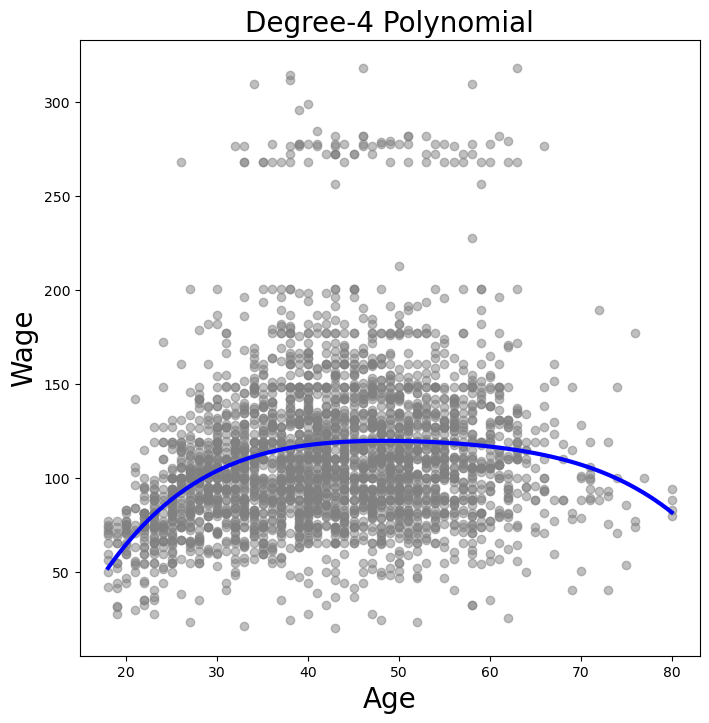

In [97]:
#the d=4 plot is same with the lab before
plot_wage_fit(age_df,
              poly_age,
              'Degree-4 Polynomial')

In [ ]:
#6b)  a step function

In [114]:
#age = Wage['age']
#y = Wage['wage']

cv_error_k = np.zeros(12)

for k in range(1, 13):
    cut_age = pd.qcut(age, k)
    X_cut_age = pd.get_dummies(cut_age)

    #d=4 is optimal
    poly = PolynomialFeatures(degree=4)
    X_poly = poly.fit_transform(X_cut_age)
    
    model = LinearRegression()
    M_CV = cross_validate(model, X_poly, Y, cv=10, scoring='neg_mean_squared_error')

    # Store the mean cross-validation error (neg_mean_squared_error returns negative values)
    cv_error_k[k-1] = -np.mean(M_CV['test_score'])  # negate the result to get positive MSE

# Display the cross-validation errors for each k
print("Cross-validation errors for different k values (1 to 12 quantiles):")
print(cv_error_k)


Cross-validation errors for different k values (1 to 12 quantiles):
[1742.24888344 1704.10005914 1660.21216778 1642.1152553  1638.7333987
 1631.9062277  1630.03658641 1628.10556159 1619.87904875 1621.24300512
 1619.72157597 1629.55810852]


In [115]:
cut_age = pd.qcut(age, 11)#pd.qcut() function to discretize age based on quantiles
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 26.0]",80.0640,2.407,33.259,0.0
"(26.0, 31.0]",101.1622,2.291,44.160,0.0
"(31.0, 34.0]",106.8027,2.586,41.308,0.0
"(34.0, 38.0]",118.1255,2.314,51.059,0.0
"(38.0, 41.0]",116.2772,2.341,49.672,0.0
"(41.0, 44.0]",119.7930,2.403,49.851,0.0
"(44.0, 47.0]",121.5035,2.429,50.017,0.0
"(47.0, 50.0]",115.5584,2.438,47.395,0.0
"(50.0, 53.0]",117.0384,2.750,42.556,0.0
"(53.0, 58.0]",117.8944,2.341,50.363,0.0


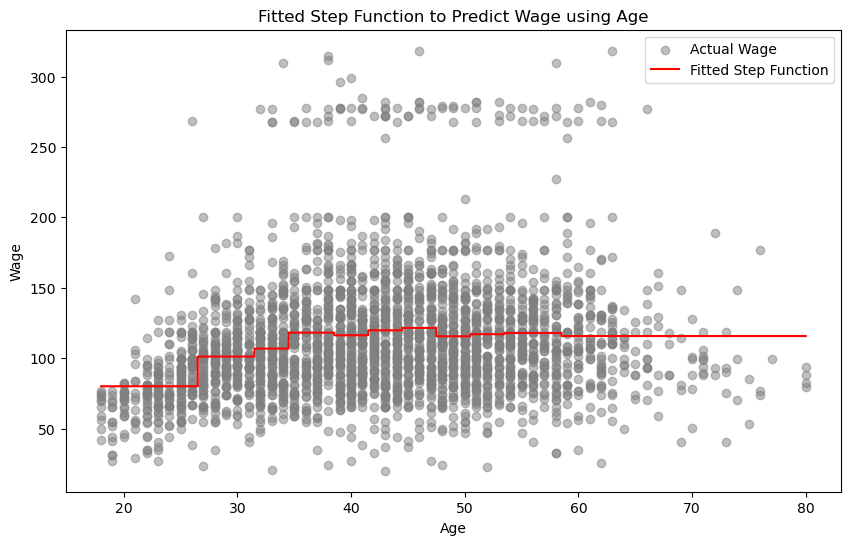

In [121]:
model = sm.OLS(y, pd.get_dummies(cut_age)).fit()
y_pred = model.predict(pd.get_dummies(cut_age))


plt.figure(figsize=(10, 6))
plt.scatter(age, y, color='gray', alpha=0.5, label='Actual Wage')
sorted_idx = np.argsort(age)
plt.step(age[sorted_idx], y_pred[sorted_idx], where='mid', color='red', label='Fitted Step Function')

plt.title('Fitted Step Function to Predict Wage using Age')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()

plt.show()

In [ ]:
#7

In [153]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +#two s_gam() terms result in smoothing spline fts # a default value for λ (lam=0.6
                     f_gam(2, lam=0)) #specify lam=0 to avoid any shrinkage
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['maritl'].cat.codes]) 

gam_full = gam_full.fit(Xgam, y)

[Text(0, 0, '1. Never Married'),
 Text(1, 0, '2. Married'),
 Text(2, 0, '3. Widowed'),
 Text(3, 0, '4. Divorced'),
 Text(4, 0, '5. Separated')]

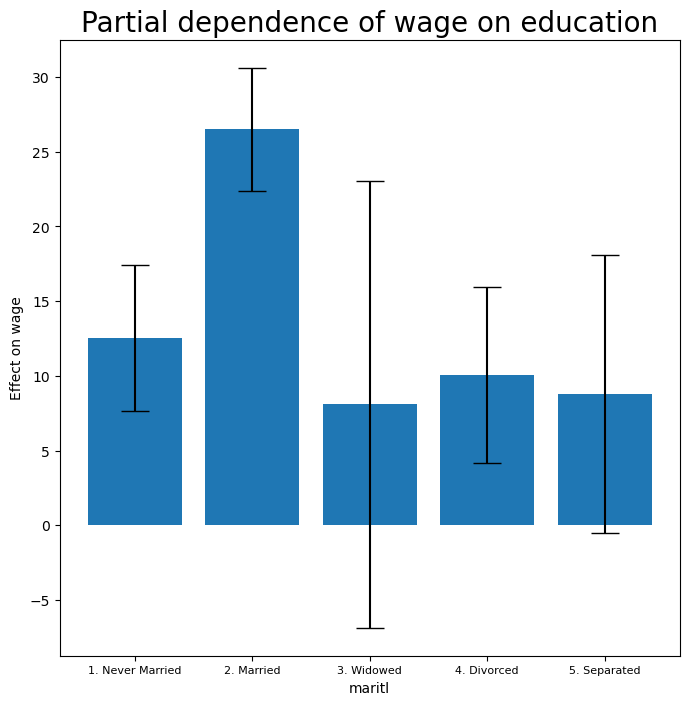

In [154]:
# we plot maritl
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('maritl')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['maritl'].cat.categories, fontsize=8)#convert the categorical series education to its array representation

In [ ]:
#as we can find from the figure Married individuals tend to have the highest positive effect on wage compared to other groups

In [155]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +#two s_gam() terms result in smoothing spline fts # a default value for λ (lam=0.6
                     f_gam(2, lam=0)) #specify lam=0 to avoid any shrinkage
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['jobclass'].cat.codes]) 

gam_full = gam_full.fit(Xgam, y)

[Text(0, 0, '1. Industrial'), Text(1, 0, '2. Information')]

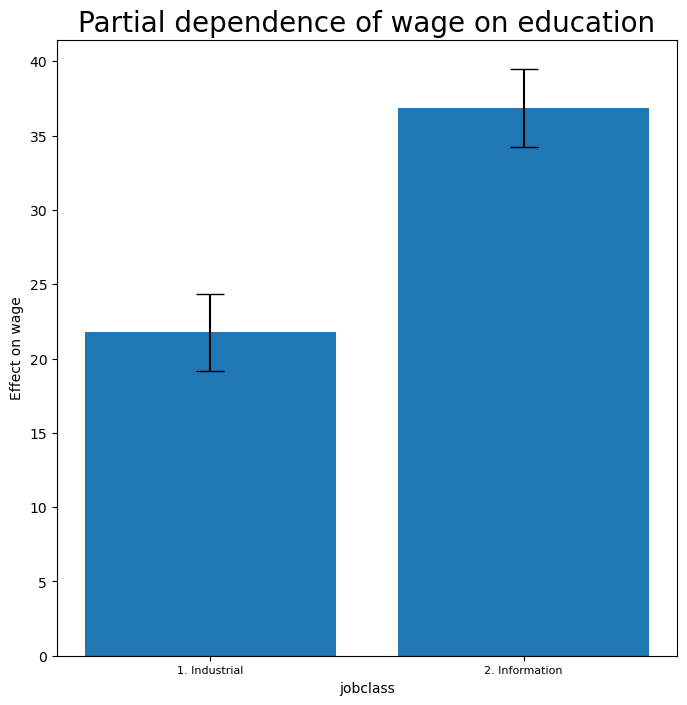

In [158]:
# we plot jobclass
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('jobclass')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8)#convert the categorical series education to its array representation

In [ ]:
#information job tends to have higher positive effect on wage compared to industrial

In [ ]:
#9 Fit some of the non-linear models investigated in this chapter to the Auto data set.

In [161]:
Auto = load_data('Auto')
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'], errors='coerce')

In [163]:
y = Auto['mpg']

In [166]:
Auto['origin'] = Auto['origin'].astype('category')

In [169]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +#two s_gam() terms result in smoothing spline fts # a default value for λ (lam=0.6
                     f_gam(2, lam=0)) #specify lam=0 to avoid any shrinkage
Xgam = np.column_stack([Auto['horsepower'],
                        Auto['weight'],
                        Auto['origin'].cat.codes]) 

gam_full = gam_full.fit(Xgam, y)

/var/folders/4t/w05mrsdn0r9d85szm0g3kg740000gn/T/ipykernel_80099/1615589008.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Auto['horsepower'], fontsize=8)#convert the categorical series education to its array representation


[Text(25.0, 0, '130'),
 Text(50.0, 0, '165'),
 Text(75.0, 0, '150'),
 Text(100.0, 0, '150'),
 Text(125.0, 0, '140'),
 Text(150.0, 0, '198'),
 Text(175.0, 0, '220'),
 Text(200.0, 0, '215'),
 Text(225.0, 0, '225'),
 Text(250.0, 0, '190')]

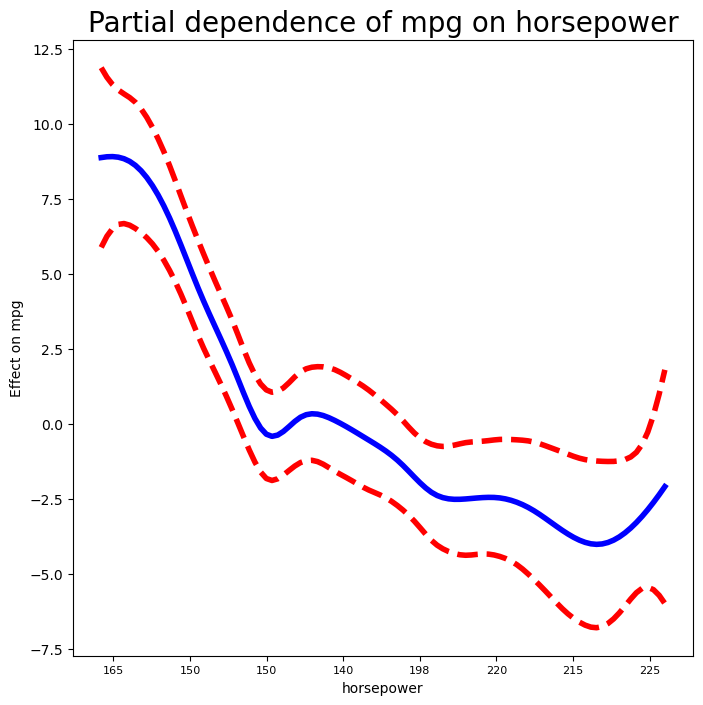

In [171]:
# plot horsepower
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 0)
ax.set_xlabel('horsepower')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on horsepower',
             fontsize=20);
ax.set_xticklabels(Auto['horsepower'], fontsize=8)

/var/folders/4t/w05mrsdn0r9d85szm0g3kg740000gn/T/ipykernel_80099/4014056697.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Auto['weight'], fontsize=8)#convert the categorical series education to its array representation


[Text(1000.0, 0, '3504'),
 Text(1500.0, 0, '3693'),
 Text(2000.0, 0, '3436'),
 Text(2500.0, 0, '3433'),
 Text(3000.0, 0, '3449'),
 Text(3500.0, 0, '4341'),
 Text(4000.0, 0, '4354'),
 Text(4500.0, 0, '4312'),
 Text(5000.0, 0, '4425'),
 Text(5500.0, 0, '3850')]

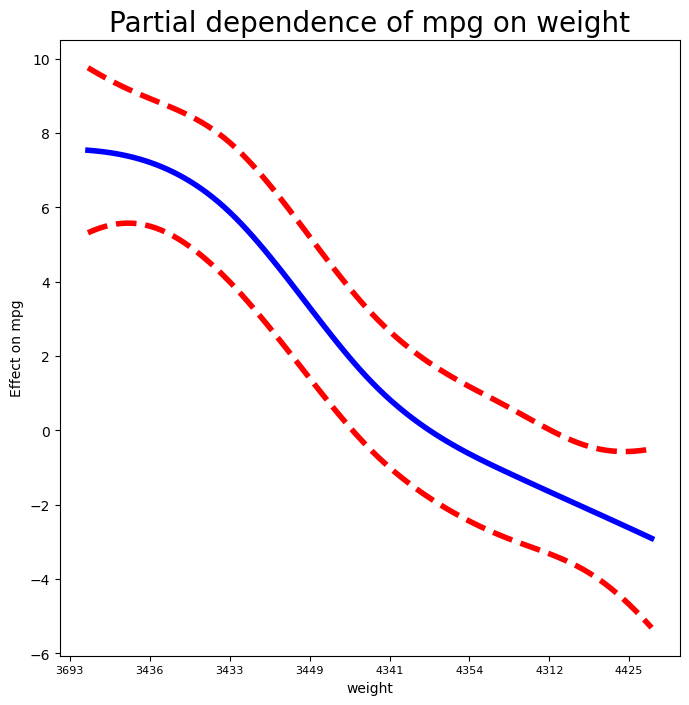

In [175]:
# plot weight
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 1)
ax.set_xlabel('weight')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on weight',
             fontsize=20);
ax.set_xticklabels(Auto['weight'], fontsize=8)

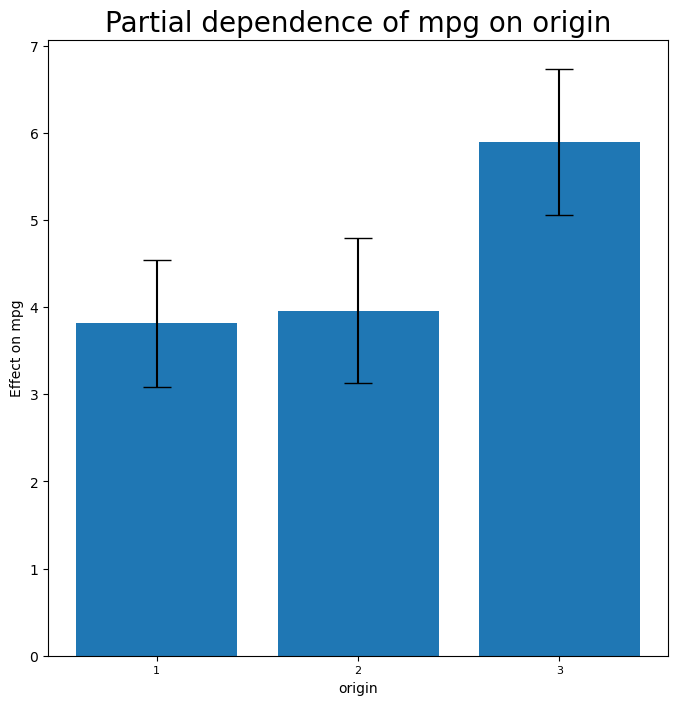

In [179]:
# plot origin
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('origin')
ax.set_ylabel('Effect on mpg')
ax.set_title('Partial dependence of mpg on origin',
             fontsize=20);
# Set the x-tick labels to match the unique categories in 'origin'
ax.set_xticks(np.arange(len(Auto['origin'].cat.categories)))  # Set ticks to match the number of categories
ax.set_xticklabels(Auto['origin'].cat.categories, fontsize=8)  # Label ticks with the category names
plt.show()

In [180]:
#The non-linear models (GAMs) show clear evidence of non-linear relationships in the Auto dataset, 
#particularly between MPG and the continuous variables horsepower and weight.

In [ ]:
#9

In [182]:
Boston = load_data('Boston')

In [ ]:
#9a)  fit a cubic polynomial regression

In [189]:
y = Boston['nox']
dis = Boston['dis']

In [ ]:
# poly() function in ISLP.models defaults to fitting orthogonal polynomials, and will result to different nums with r 

In [192]:
poly_dis = MS([poly('dis', degree=3)]).fit(Boston)
M = sm.OLS(y, poly_dis.transform(Boston)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


Degree 1: RSS = 2.7686
Degree 2: RSS = 2.0353
Degree 3: RSS = 1.9341
Degree 4: RSS = 1.9330
Degree 5: RSS = 1.9153
Degree 6: RSS = 1.8783
Degree 7: RSS = 1.8495
Degree 8: RSS = 1.8356
Degree 9: RSS = 1.8333
Degree 10: RSS = 1.8322


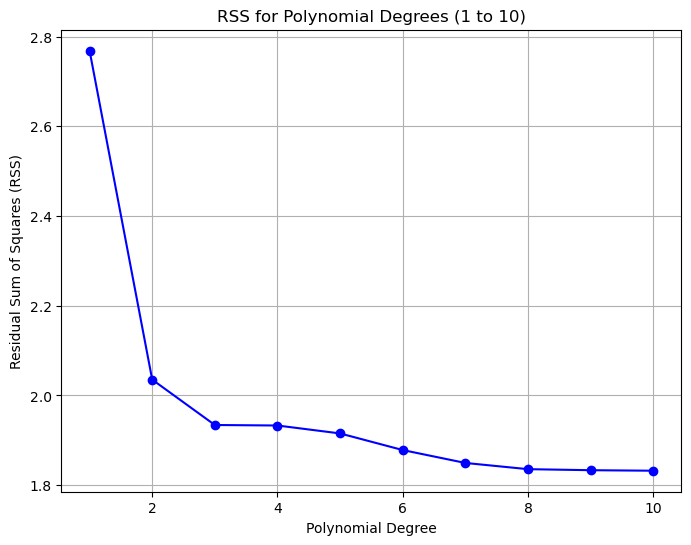

In [198]:
# 9b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10)
rss_values = {}

for d in range(1,11):
    poly_dis = MS([poly('dis', degree=d)]).fit(Boston)
    M = sm.OLS(y, poly_dis.transform(Boston)).fit()
    rss_values[d] = np.sum(M.resid**2)
    print(f"Degree {d}: RSS = {rss_values[d]:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(list(rss_values.keys()), list(rss_values.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Polynomial Degree')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.title('RSS for Polynomial Degrees (1 to 10)')
plt.grid(True)
plt.show()
    

In [ ]:
#9c)Perform cross-validation

In [201]:
X, Y = Boston.drop(columns=['nox']), Boston['nox']
cv_error = np.zeros(10)
H = np.array(Boston['dis'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,11)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Boston.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([0.00552387, 0.00407945, 0.00387476, 0.00388752, 0.00416486,
       0.00538428, 0.01106878, 0.0081214 , 0.01761638, 0.00443034])

In [203]:
np.sort(cv_error)

array([0.00387476, 0.00388752, 0.00407945, 0.00416486, 0.00443034,
       0.00538428, 0.00552387, 0.0081214 , 0.01106878, 0.01761638])

In [ ]:
#optimal d = 3 with the least cv_error

In [ ]:
#9d) Use the bs() function from the ISLP.models module to fit a regression spline to predict nox using dis
#using four degrees of freedom

In [234]:
bs_dis0 = MS([bs('dis',
                 df=4)]).fit(Boston)
Xbs0 = bs_dis0.transform(Boston)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


In [ ]:
#9e)fit a regression spline for a range of degrees of freedom

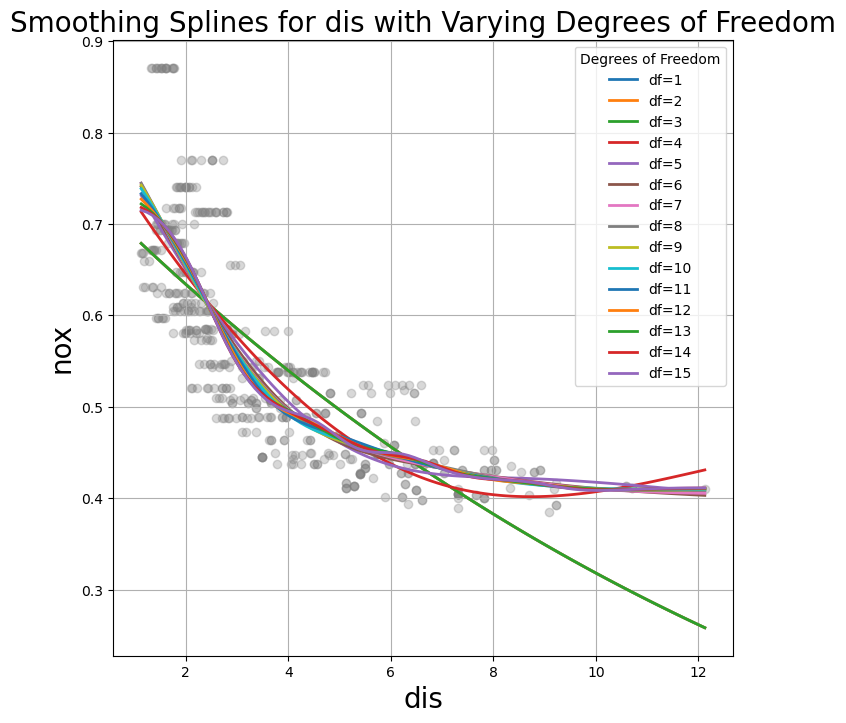

Degree of Freedom 1: RSS = 2.5268
Degree of Freedom 2: RSS = 2.5268
Degree of Freedom 3: RSS = 2.5268
Degree of Freedom 4: RSS = 2.0632
Degree of Freedom 5: RSS = 1.9558
Degree of Freedom 6: RSS = 1.9174
Degree of Freedom 7: RSS = 1.9053
Degree of Freedom 8: RSS = 1.9015
Degree of Freedom 9: RSS = 1.8985
Degree of Freedom 10: RSS = 1.8933
Degree of Freedom 11: RSS = 1.8811
Degree of Freedom 12: RSS = 1.8630
Degree of Freedom 13: RSS = 1.8551
Degree of Freedom 14: RSS = 1.8559
Degree of Freedom 15: RSS = 1.8458


In [247]:
X_dis = np.asarray(Boston['dis']).reshape((-1, 1))  
y = Boston['nox']

dis_grid = np.linspace(X_dis.min(), X_dis.max(), 100).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_dis, y, facecolor='gray', alpha=0.3)


rss_values = {}

for df in range(1,16):
    n_splines = max(4, df + 1)  # Ensure at least 4 splines
    
    gam = LinearGAM(s(0, n_splines=n_splines, lam=0.6))
    gam.fit(X_dis, y)
    
    y_pred = gam.predict(dis_grid)
    
    # Calculate the RSS (Residual Sum of Squares)
    rss = np.sum((y - gam.predict(X_dis)) ** 2)
    rss_values[df] = rss
    
    ax.plot(dis_grid, y_pred, label=f'df={df}', linewidth=2)

# Customize the plot
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20)
ax.legend(title='Degrees of Freedom')
plt.title('Smoothing Splines for dis with Varying Degrees of Freedom', fontsize=20)
plt.grid(True)
plt.show()

# Print the RSS values for each degree of freedom
for df, rss in rss_values.items():
    print(f'Degree of Freedom {df}: RSS = {rss:.4f}')


In [ ]:
#9f) Perform cross-validation or another approach in order to select the best degrees of freedom

In [248]:
cv_error_k = np.zeros(13)  

for df in range(3, 16):#df>=3
    bs_dis0 = MS([bs('dis', df=df)]).fit(Boston)
    Xbs0 = bs_dis0.transform(Boston)
    
    model = LinearRegression()
    M_CV = cross_validate(model, Xbs0, Y, cv=Boston.shape[0], scoring='neg_mean_squared_error')
    
    cv_error_k[df-3] = -np.mean(M_CV['test_score'])

print("Cross-validation errors for different df values (3 to 15):")
print(cv_error_k)

# Finding the best degrees of freedom based on lowest MSE
best_df_index = np.argmin(cv_error_k)
best_df = range(3, 16)[best_df_index]
print(f"The best degrees of freedom for the regression spline is {best_df} with MSE of {cv_error_k[best_df_index]}")


Cross-validation errors for different df values (3 to 15):
[0.00387476 0.00389303 0.0037043  0.0037046  0.0037111  0.00370023
 0.00373122 0.00369321 0.00371523 0.00370091 0.00370819 0.00373409
 0.00375597]
The best degrees of freedom for the regression spline is 10 with MSE of 0.0036932129113343495


In [ ]:
#10. This question relates to the College data set

In [254]:
College = load_data('College')

In [ ]:
#10 a)  Split the data into a training set and a test set

In [260]:
X = College.drop(columns='Outstate') 
y = College['Outstate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=66)

In [278]:
train_df = X_train.copy()
train_df['Outstate'] = y_train

In [286]:
test_df = X_test.copy()
test_df['Outstate'] = y_test

In [281]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [282]:
design = MS(train_df.columns.drop('Outstate')).fit(train_df)
Y = np.array(y_train)
X = design.transform(train_df)
sigma2 = OLS(Y,X).fit().scale

In [283]:
#o freeze the frst argument with our estimate of σ2
neg_Cp = partial(nCp, sigma2)

In [291]:
#forward stepwise until any further additions to the model do not result in an improvement in the evaluation score.
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=3)

In [292]:
#Using neg_Cp results in a smaller model
College_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
College_Cp.fit(train_df, Y)
College_Cp.selected_state_

('Expend', 'Private', 'Terminal')

In [ ]:
#10b)

In [ ]:
College

In [295]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1) +# s_gam() terms result in smoothing spline fts # a default value for λ (lam=0.6
                     f_gam(2, lam=0))
Xgam = np.column_stack([test_df['Expend'],
                        test_df['Terminal'],
                        test_df['Private'].cat.codes]) 

gam_full = gam_full.fit(Xgam, y_test)

Text(0.5, 1.0, 'Partial dependence of out-of-state tuition on Expend- default lam=0.6')

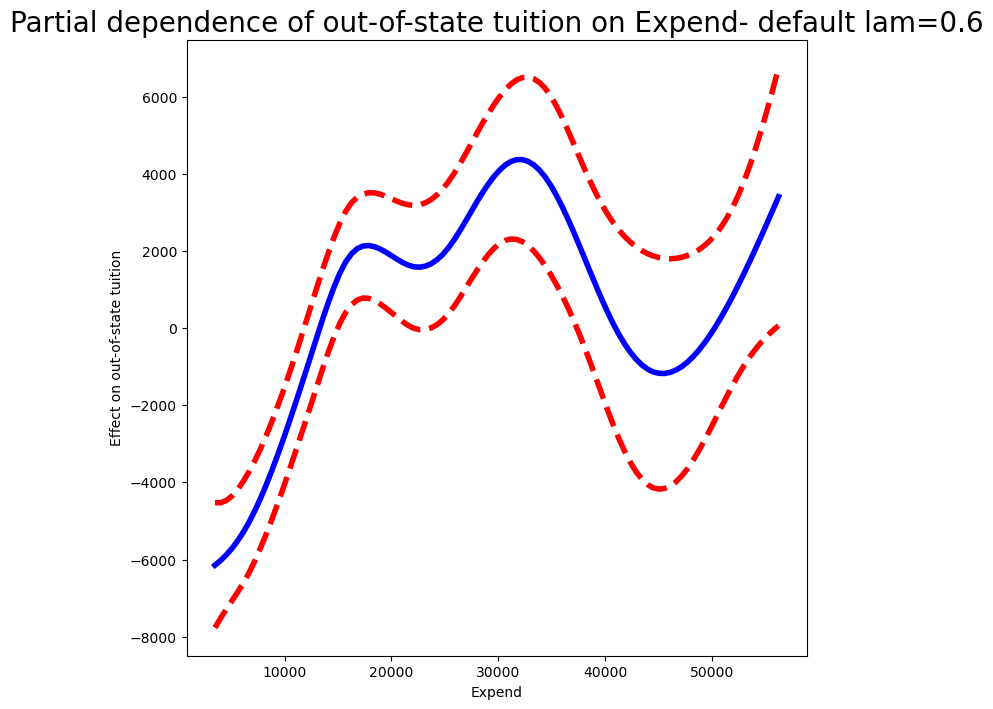

In [298]:
#plot Expend
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Expend')
ax.set_ylabel('Effect on out-of-state tuition')
ax.set_title('Partial dependence of out-of-state tuition on Expend- default lam=0.6',
             fontsize=20)

Text(0.5, 1.0, 'Partial dependence of out-of-state tuition on Terminal - default lam=0.6')

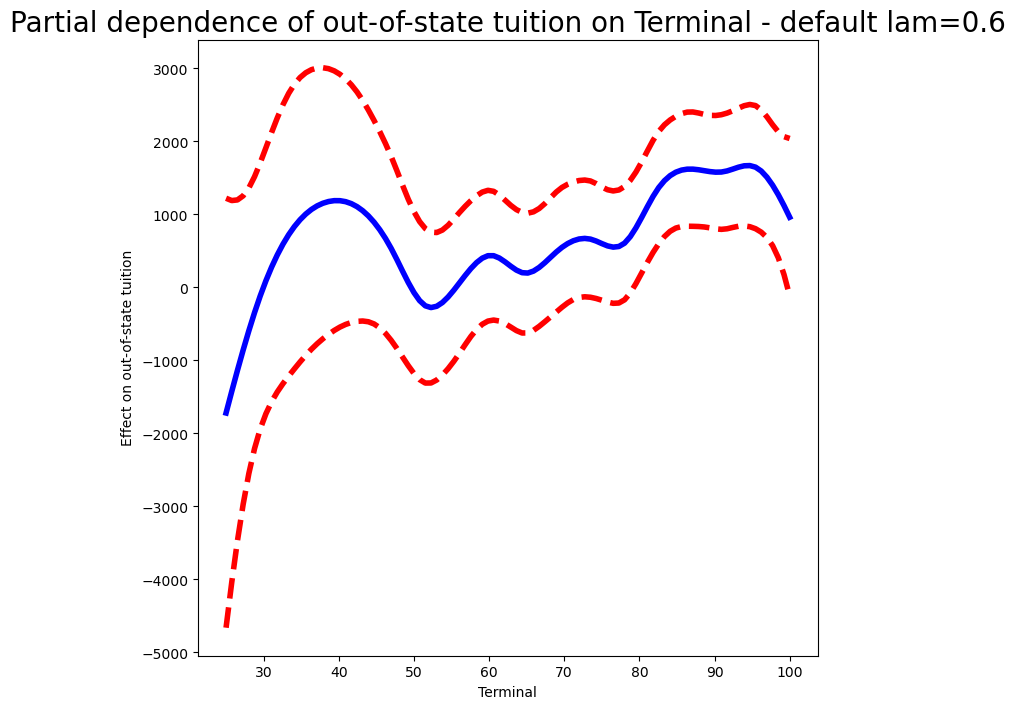

In [297]:
#plot Expend
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Terminal')
ax.set_ylabel('Effect on out-of-state tuition')
ax.set_title('Partial dependence of out-of-state tuition on Terminal - default lam=0.6',
             fontsize=20)

Text(0.5, 1.0, 'Partial dependence of out-of-state tuition on Private - default lam=0.6')

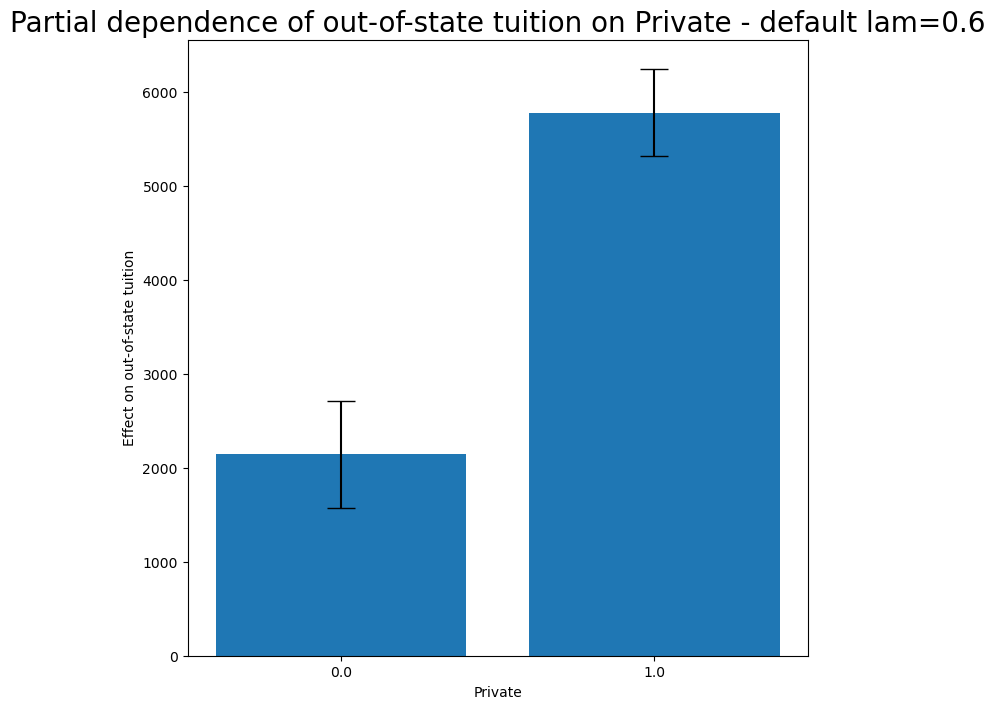

In [299]:
#plot Expend
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 2)
ax.set_xlabel('Private')
ax.set_ylabel('Effect on out-of-state tuition')
ax.set_title('Partial dependence of out-of-state tuition on Private - default lam=0.6',
             fontsize=20)

In [ ]:
#10 c)

In [304]:
predictions = gam_full.predict(Xgam)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 3896722.1310598524
R^2 Score: 0.7585469337129267


In [ ]:
#The model explains approximately 75.85% of the variance in out-of-state tuition, 
#indicating a strong fit,
#although the high MSE suggests potential influences from outliers

In [ ]:
#e) Variables "Expend" and "Terminal" show evidence of non-linear relationships with the "Outstate" tuition

In [ ]:
#11)

In [332]:
#a)
np.random.seed(0)
X1 = np.random.normal(0, 1, 100)
X2 = np.random.normal(0, 1, 100)
Y = 3 + 2 * X1 + 3 * X2 + np.random.normal(0, 1, 100) 

In [333]:
#b)Write a function simple_reg() that takes two arguments outcome and feature
def simple_reg(outcome, feature):
    model = LinearRegression().fit(feature.reshape(-1, 1), outcome)
    return model.intercept_, model.coef_[0]
    

In [334]:
#c)beta1
beta1 = 0

In [335]:
#d)
adjusted_Y = Y - beta1 * X1
beta0, beta2 = simple_reg(adjusted_Y, X2)

In [336]:
#e)
adjusted_Y_e = Y - beta2 * X2
beta0, beta1 = simple_reg(adjusted_Y_e, X1)

In [337]:
#f)
# Initialization for the loop
beta0_values = []
beta1_values = [beta1]
beta2_values = [beta2]

# Iteration process
for _ in range(1000):
    # Update using step (d)
    adjusted_Y_d = Y - beta1 * X1
    beta0, beta2 = simple_reg(adjusted_Y_d, X2)
    beta0_values.append(beta0)
    beta2_values.append(beta2)
    
    # Update using step (e)
    adjusted_Y_e = Y - beta2 * X2
    beta0, beta1 = simple_reg(adjusted_Y_e, X1)
    beta0_values.append(beta0)
    beta1_values.append(beta1)

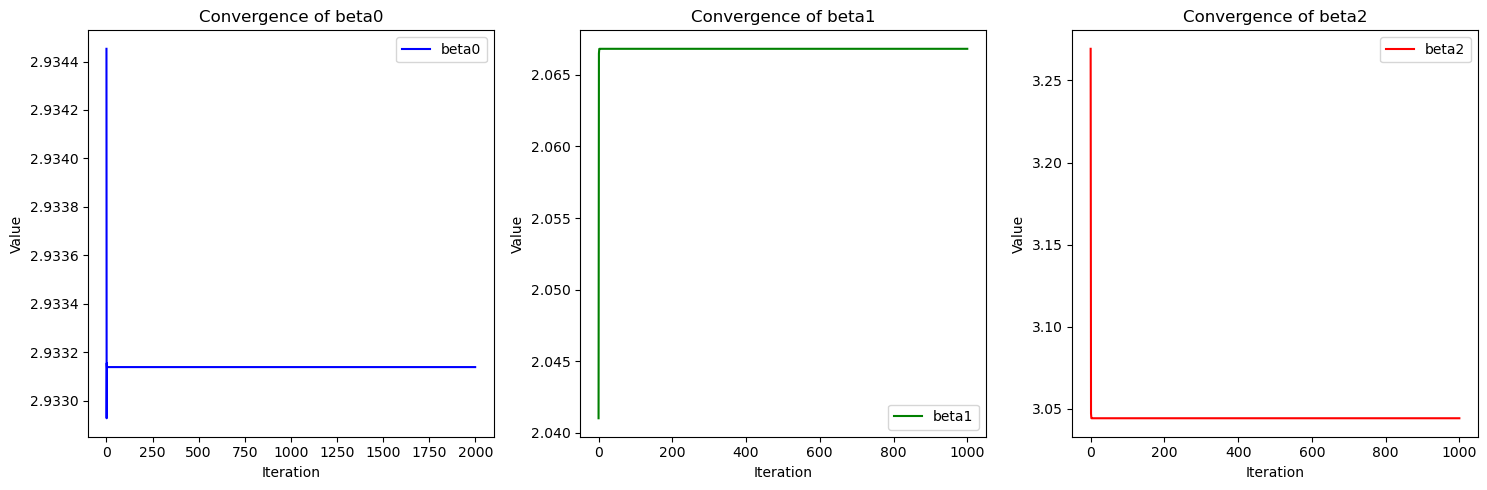

In [338]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(beta0_values, label='beta0', color='blue')
plt.title('Convergence of beta0')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(beta1_values, label='beta1', color='green')
plt.title('Convergence of beta1')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(beta2_values, label='beta2', color='red')
plt.title('Convergence of beta2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Y = 3 + 2 * X1 + 3 * X2 + np.random.normal(0, 1, 100) 

In [339]:
#g)the coefficients from e) are close to the mlr coefficients

X = np.column_stack((X1, X2))
model = LinearRegression().fit(X, Y)
beta0_mlr, beta1_mlr, beta2_mlr = model.intercept_, model.coef_[0], model.coef_[1]


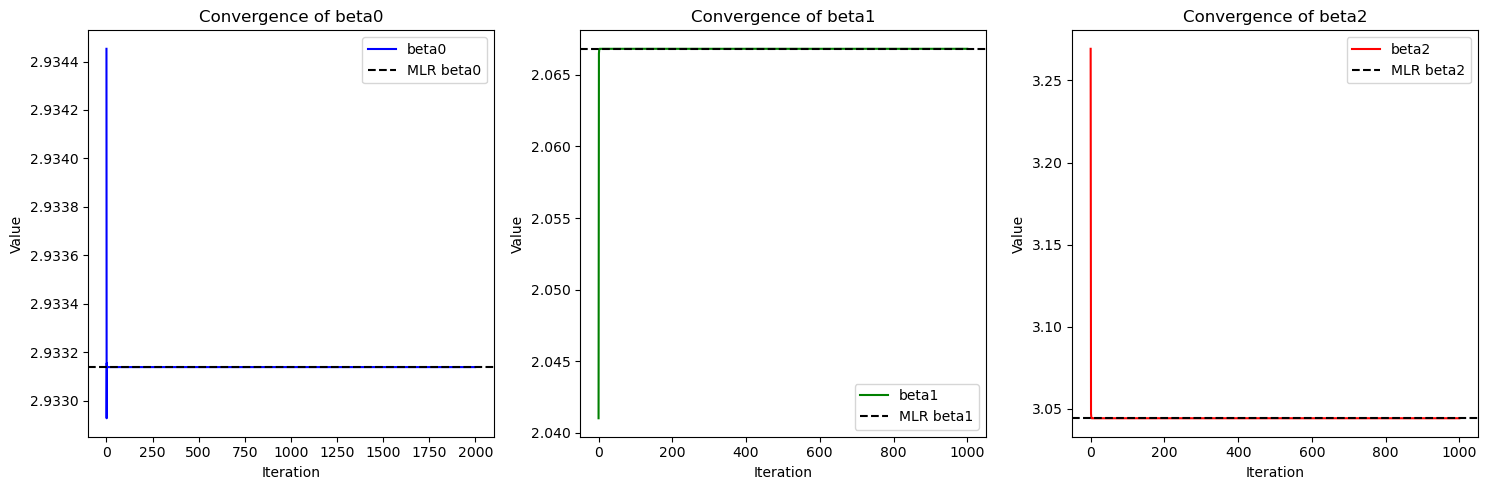

In [340]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(beta0_values, label='beta0', color='blue')
plt.axhline(y=beta0_mlr, color='black', linestyle='--', label='MLR beta0')
plt.title('Convergence of beta0')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(beta1_values, label='beta1', color='green')
plt.axhline(y=beta1_mlr, color='black', linestyle='--', label='MLR beta1')
plt.title('Convergence of beta1')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(beta2_values, label='beta2', color='red')
plt.axhline(y=beta2_mlr, color='black', linestyle='--', label='MLR beta2')
plt.title('Convergence of beta2')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [343]:
#h)

t = 0.0001  # Define tolerance level
for i in range(len(beta0_values)):
    if abs(beta0_values[i] - beta0_mlr) < t and abs(beta1_values[i] - beta1_mlr) < t and abs(beta2_values[i] - beta2_mlr) < t:
        print(f"Convergence reached at iteration {i}")
        break

Convergence reached at iteration 2


In [344]:
#12.
np.random.seed(66)
n = 100
p = 100
X = np.random.normal(0, 1, (n, p))
true_betas = np.linspace(1, 2, p)  
Y = X.dot(true_betas) + np.random.normal(0, 1, n)

In [346]:
mlr_model = LinearRegression().fit(X, Y)
mlr_betas = mlr_model.coef_

In [350]:
betas = np.zeros(p)
beta_values = [betas.copy()]

epsilon = 0.01
max_iterations = 1600
converged = False

for iteration in range(max_iterations):
    for i in range(p):
        Y_adjusted = Y - X.dot(betas) + betas[i] * X[:, i]
        
        slr_model = LinearRegression().fit(X[:, i].reshape(-1, 1), Y_adjusted)
        betas[i] = slr_model.coef_[0]
    
    beta_values.append(betas.copy())
    
    if np.max(np.abs(betas - mlr_betas)) < epsilon:
        converged = True
        break

beta_values = np.array(beta_values)

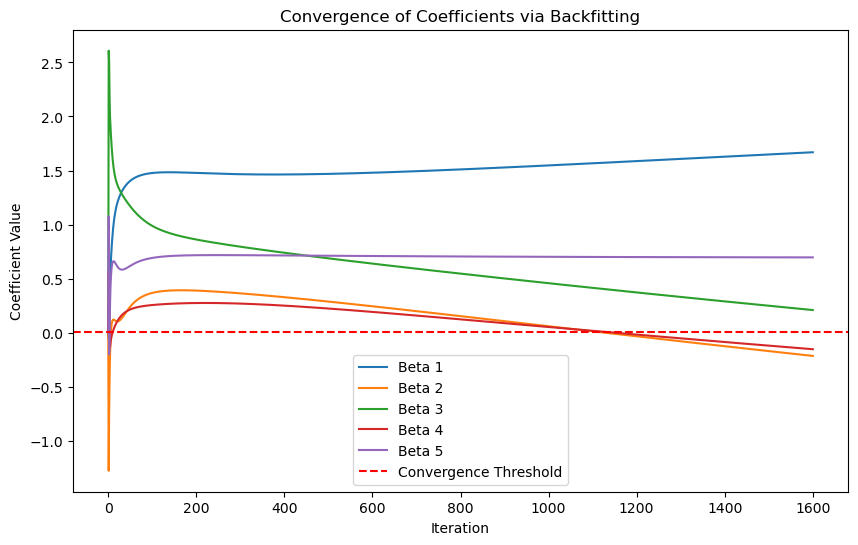

No convergence within the maximum iterations


In [353]:
plt.figure(figsize=(10, 6))
for i in range(min(5, p)):  # Plot the first 3 coefficients
    plt.plot(beta_values[:, i], label=f'Beta {i+1}')

plt.axhline(y=epsilon, color='r', linestyle='--', label='Convergence Threshold')
plt.title('Convergence of Coefficients via Backfitting')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

# Print results
if converged:
    print(f"Convergence reached at iteration {iteration}")
else:
    print("No convergence within the maximum iterations")


In [ ]:
#seems like only two parameters converge and more interations are needed